In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scanpy as sc
import sklearn
from anndata import read_h5ad
from sklearn.feature_selection import mutual_info_classif as MIC
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
# from scRFE.scRFE import scRFE
import matplotlib
import anndata

In [2]:
from preprocess import *

# Validation that cell types in both datasets have same gene markers

## Reading the Lee Rubin dataset

In [3]:
lee_rubin_pth = 'datasets/lee_rubin.h5ad'

try:
    lee_rubin_brain = sc.read_h5ad(lee_rubin_pth)
    
except:
    data = pd.read_csv('datasets/expression_Aging_mouse_brain_portal_data_updated.txt', delimiter = '\t', chunksize = 1000)
    pd_df = pd.concat(data)

    X = pd_df.values
    X = X.T

    lee_rubin_brain = anndata.AnnData(X = X[1:, :])
    lee_rubin_brain.obs = pd.DataFrame(pd_df.columns.to_list()[1:], columns=['cell'])
    lee_rubin_brain.var = pd.DataFrame(pd_df['GENE'].to_list(), columns=['gene'])
    
data = pd.read_csv('datasets/meta_Aging_mouse_brain_portal_data.txt', delimiter = '\t', chunksize = 1000)
meta_df = pd.concat(data)

/opt/anaconda3/envs/neurogenomics/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [4]:
lee_rubin_brain.obs['cell_type'] = meta_df['cell_type'].tolist()[1:]
lee_rubin_brain.obs['cell_type_by_age'] = meta_df['cell_type_by_age'].tolist()[1:]
lee_rubin_brain.obs['cell_class'] = meta_df['cell_class'].tolist()[1:]
lee_rubin_brain.obs['cell_class_by_age'] = meta_df['cell_class_by_age'].tolist()[1:]
lee_rubin_brain.obs['all_cells_by_age'] = meta_df['all_cells_by_age'].tolist()[1:]
lee_rubin_brain.obs['nGene'] = meta_df['nGene'].tolist()[1:]
lee_rubin_brain.obs['nUMI'] = meta_df['nUMI'].tolist()[1:]

In [16]:
lee_rubin_brain

AnnData object with n_obs × n_vars = 37069 × 14699
    obs: 'cell', 'cell_type', 'cell_type_by_age', 'cell_class', 'cell_class_by_age', 'all_cells_by_age', 'nGene', 'nUMI'
    var: 'gene'
    uns: 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

## Reading/preprocessing the Tabula Muris dataset

In [10]:
parameters['min_cells'] = 0.01

In [11]:
tabula_muris_pth = "datasets/tabula-muris-senis-facs-official-raw-obj.h5ad"
tabula_muris_brain = load_tabula_muris(tabula_muris_pth, **parameters)

Loading the data...
Data loaded (dimension: (20666, 22966) )!
Removing cells and genes...
Highly variable gene selection...
Data final dimension: (20510, 2697)


In [17]:
tabula_muris_brain

AnnData object with n_obs × n_vars = 20510 × 2697
    obs: 'FACS.selection', 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'sex', 'subtissue', 'tissue', 'n_genes', 'n_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

## Creating UMAP of Tabula Muris and Lee Rubin

In [13]:
sc.pp.neighbors(lee_rubin_brain, n_neighbors=15, n_pcs=50)
print("Neighbors complete")
sc.tl.umap(lee_rubin_brain)

         Falling back to preprocessing with `sc.pp.pca` and default params.
Neighbors complete


In [12]:
sc.pp.neighbors(tabula_muris_brain, n_neighbors=15, n_pcs=50)
print("Neighbors complete")
sc.tl.umap(tabula_muris_brain)

         Falling back to preprocessing with `sc.pp.pca` and default params.


/opt/anaconda3/envs/neurogenomics/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Neighbors complete


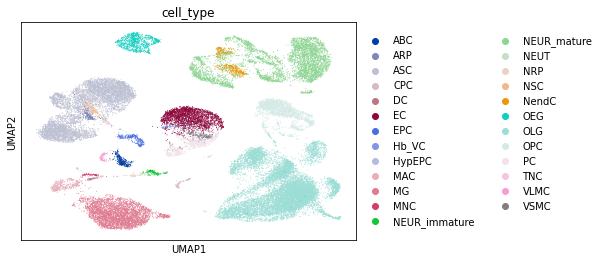

In [18]:
sc.pl.umap(lee_rubin_brain, color = 'cell_type')

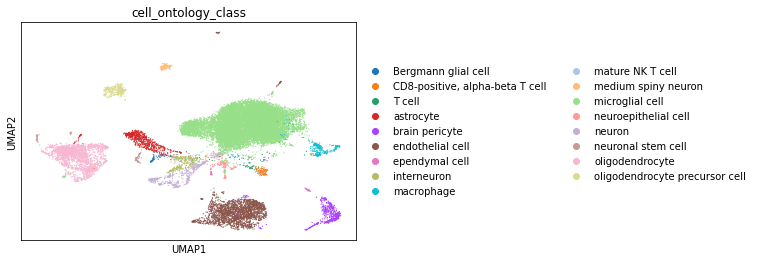

In [19]:
sc.pl.umap(tabula_muris_brain, color = 'cell_ontology_class')

## Dataset focusing on select cell types 

These are the cell types that have more than 300 cells!

In [53]:
cell_of_interest = {'Tabula Muris' : ['oligodendrocyte', 'neuron', 'macrophage', 'astrocyte', 'microglial cell', 'endothelial cell', 'brain pericyte'], 
                    'Lee Rubin' : ['OLG', 'NEUR_mature', 'MAC', 'ASC', 'MG', 'EC', 'PC']}

cell_of_interest = pd.DataFrame(cell_of_interest)

In [54]:
cell_indxs = np.full((tabula_muris_brain.shape[0]), False, dtype=bool)
for name in cell_of_interest['Tabula Muris'].tolist():
    cell_indxs = np.logical_or(cell_indxs, np.array(tabula_muris_brain.obs.cell_ontology_class == name))
    
tabula_muris_brain_CofI = tabula_muris_brain[cell_indxs, :] 

tabula_muris_brain_CofI

View of AnnData object with n_obs × n_vars = 19325 × 2697
    obs: 'FACS.selection', 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'sex', 'subtissue', 'tissue', 'n_genes', 'n_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'neighbors', 'umap', 'cell_ontology_class_colors'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

In [55]:
cell_indxs = np.full((lee_rubin_brain.shape[0]), False, dtype=bool)
for name in cell_of_interest['Lee Rubin'].tolist():
    cell_indxs = np.logical_or(cell_indxs, np.array(lee_rubin_brain.obs.cell_type == name))
    
lee_rubin_brain_CofI = lee_rubin_brain[cell_indxs, :] 

lee_rubin_brain_CofI

View of AnnData object with n_obs × n_vars = 31701 × 14699
    obs: 'cell', 'cell_type', 'cell_type_by_age', 'cell_class', 'cell_class_by_age', 'all_cells_by_age', 'nGene', 'nUMI'
    var: 'gene'
    uns: 'neighbors', 'umap', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

## Differential gene expression

In [56]:
sc.tl.rank_genes_groups(lee_rubin_brain_CofI, 'cell_type', method = 'wilcoxon')

In [57]:
sc.tl.rank_genes_groups(tabula_muris_brain_CofI, 'cell_ontology_class', method = 'wilcoxon')

## Overview of results

We can see the plot that matches the gene markers between our two atasets; hence, we are analyzing the same cell types

## Aging gene markers per cell type: comparison

In [101]:
cell_brain = {}

for CT in cell_of_interest['Tabula Muris']:
    parameters_CT = parameters
    parameters_CT["cell_classes"] = CT
    
    cell_brain[CT] = load_tabula_muris(tabula_muris_pth, **parameters)
    # cell_brain[CT] = cell_brain[CT][cell_brain[CT].obs['age'] != '18m']
    print(cell_brain[CT], "WOOT")
    sc.tl.rank_genes_groups(cell_brain[CT], 'age', method = 'wilcoxon')

Loading the data...
Data loaded (dimension: (2094, 22966) )!
Removing cells and genes...
Highly variable gene selection...
Data final dimension: (2037, 2571)
View of AnnData object with n_obs × n_vars = 1522 × 2571
    obs: 'FACS.selection', 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'sex', 'subtissue', 'tissue', 'n_genes', 'n_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg' WOOT
Loading the data...
Data loaded (dimension: (484, 22966) )!
Removing cells and genes...
Highly variable gene selection...
Data final dimension: (478, 4168)
View of AnnData object with n_obs × n_vars = 360 × 4168
    obs: 'FACS.selection', 'age', 'cell', 'cell_ontology_class', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'sex', 'subtissue', 'tissue', 'n_genes', 'n_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg' 

oligodendrocyte (1522, 2571)


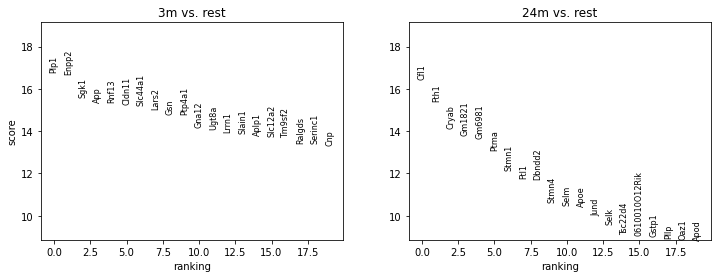

neuron (360, 4168)


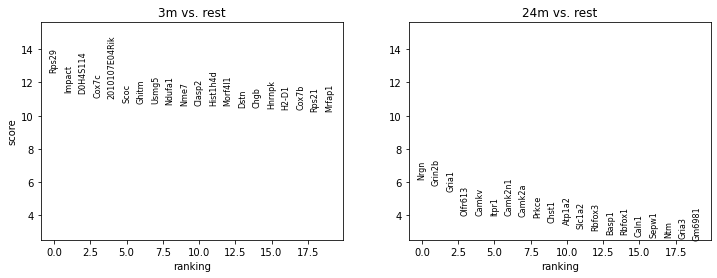

macrophage (223, 2881)


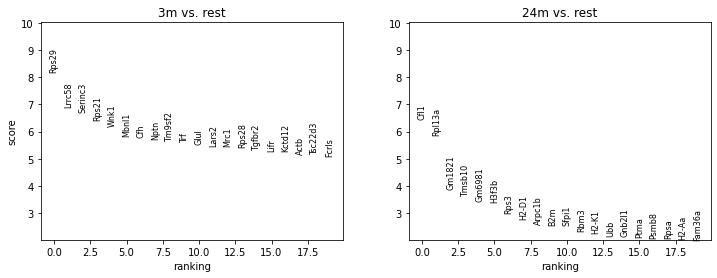

astrocyte (481, 3605)


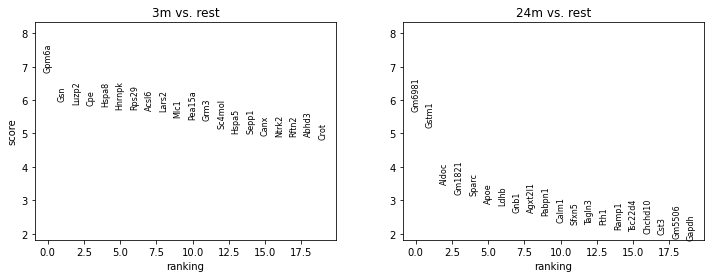

microglial cell (8740, 1527)


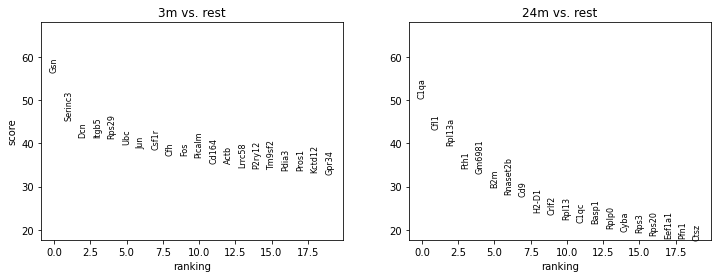

endothelial cell (872, 2756)


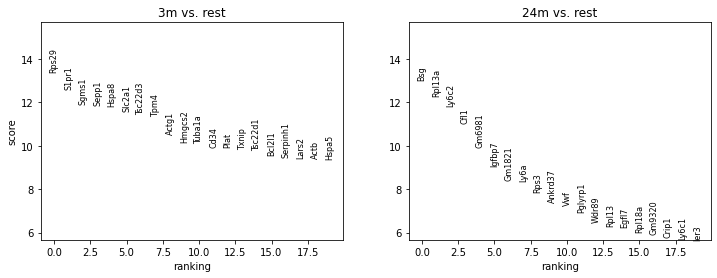

brain pericyte (218, 3223)


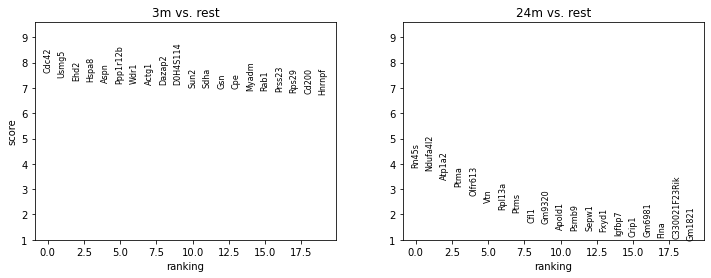

In [145]:
for CT in cell_of_interest['Tabula Muris']:
    sc.pl.rank_genes_groups(cell_brain[CT])

In [175]:
cell_gene_names = []
for gene in cell_brain['MG'].uns['rank_genes_groups']['names']['21-22mo']:
    cell_gene_names.append(cell_brain['MG'].var['gene'][gene])

In [176]:
score_LR, score_TM = [], []
gene_name = []

for i, gene in enumerate(cell_gene_names):
    indx = np.where(cell_brain['microglial cell'].uns['rank_genes_groups']['names']['24m'] == gene)[0]
    if indx.shape[0] == 0:
        continue
    score_LR.append(cell_brain['MG'].uns['rank_genes_groups']['logfoldchanges']['21-22mo'][i])
    score_TM.append(cell_brain['microglial cell'].uns['rank_genes_groups']['logfoldchanges']['24m'][indx[0]])
    gene_name.append(gene)

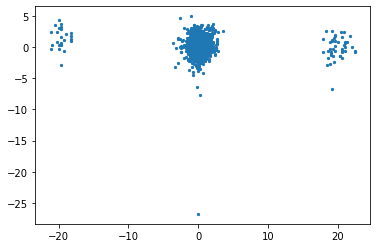

In [177]:
plt.scatter(score_LR, score_TM, s = 5)

## Aging markers TM for training

In [ ]:
### Select the top 10% And then choose the top 

### Analysis on unique cells

In [30]:
parameters_CT = parameters
parameters_CT["cell_classes"] = [CT]
X_train, X_test, y_train, y_test = scRNA_dataset(dir_, **parameters_CT)


Loading the data...
Data loaded (dimension: (20666, 22966) )!
Removing cells and genes...


/opt/anaconda3/envs/neurogenomics/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


Highly variable gene selection...
Selecting different cell types...
Returning normalized data!


In [32]:
X_train.columns

Index(['0610007P22Rik', '0610010O12Rik', '0610012G03Rik', '0610037P05Rik',
       '1110001J03Rik', '1110002B05Rik', '1110003E01Rik', '1110004E09Rik',
       '1110004F10Rik', '1110008P14Rik',
       ...
       'Zmat2', 'Znhit1', 'Znhit2-ps', 'Zranb1', 'Zrsr1', 'Zwint', 'Zxdc',
       'Zyx', 'Zzef1', 'Zzz3'],
      dtype='object', length=1540)

In [54]:
CT_accuracy = []

for CT in cell_types:
    parameters_CT = parameters
    parameters_CT["cell_classes"] = [CT]
     
    X_train, X_test, y_train, y_test = scRNA_dataset(dir_, **parameters_CT)
    
    X_train, X_test = X_train.dropna(axis = 1), X_test.dropna(axis = 1)
    
    clf = RandomForestClassifier(max_depth=15, random_state=0)
    
    clf.fit(X_train, y_train)
    
    importances_indxs = np.argsort(-clf.feature_importances_)[:10]
    importances = clf.feature_importances_[importances_indxs]
    forest_importances = pd.Series(importances, index=X_train.columns[importances_indxs])
    
    print(forest_importances)
    
    CT_accuracy.append(clf.score(X_test, y_test))
    

Loading the data...
Data loaded (dimension: (20666, 22966) )!
Removing cells and genes...


/opt/anaconda3/envs/neurogenomics/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


Highly variable gene selection...
Selecting different cell types...
Returning normalized data!
Cox8a            0.009907
Cox6c            0.009516
Lars2            0.009157
Gnb1             0.006911
2010107E04Rik    0.006520
Rsbn1l           0.006210
Flnb             0.006183
Atp5k            0.006121
Nrxn2            0.006067
Eif2ak2          0.005522
dtype: float64
Loading the data...
Data loaded (dimension: (20666, 22966) )!
Removing cells and genes...


/opt/anaconda3/envs/neurogenomics/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


Highly variable gene selection...
Selecting different cell types...
Returning normalized data!
Cd74      0.018033
Lars2     0.009988
Inpp4a    0.008253
Zyx       0.006190
Hlx       0.005722
Irak4     0.005555
Ankfy1    0.005422
Psmc6     0.005202
Cox6c     0.005122
Rpl13a    0.004950
dtype: float64
Loading the data...
Data loaded (dimension: (20666, 22966) )!
Removing cells and genes...


/opt/anaconda3/envs/neurogenomics/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


Highly variable gene selection...
Selecting different cell types...
Returning normalized data!
Lars2            0.034040
Gnb1             0.014732
S1pr1            0.014009
Tpm4             0.013771
9430020K01Rik    0.012359
Egfl7            0.011404
Slc2a1           0.010703
0610010O12Rik    0.009357
Sgms1            0.008729
Rpl13a           0.008357
dtype: float64
Loading the data...
Data loaded (dimension: (20666, 22966) )!
Removing cells and genes...


/opt/anaconda3/envs/neurogenomics/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


Highly variable gene selection...
Selecting different cell types...
Returning normalized data!
Lars2       0.021864
Gsn         0.009214
Rpl13a      0.008384
Map1lc3a    0.007708
Sdc4        0.006805
Atp1b2      0.006703
Pltp        0.006571
Pdcd4       0.006516
Snrk        0.006489
Sparcl1     0.006408
dtype: float64
Loading the data...
Data loaded (dimension: (20666, 22966) )!
Removing cells and genes...


/opt/anaconda3/envs/neurogenomics/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


Highly variable gene selection...
Selecting different cell types...
Returning normalized data!
Lars2            0.015831
0610010O12Rik    0.013416
Gstm1            0.009982
Cpe              0.009826
Gnb1             0.009219
Aldoc            0.007729
Gpm6a            0.007334
Csrp1            0.006605
Ttyh1            0.006433
Clu              0.006247
dtype: float64
Loading the data...
Data loaded (dimension: (20666, 22966) )!
Removing cells and genes...


/opt/anaconda3/envs/neurogenomics/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


Highly variable gene selection...
Selecting different cell types...
Returning normalized data!
Gsn       0.036949
Rpl13a    0.025702
Jun       0.021051
Lars2     0.018593
Dcn       0.015898
Notch2    0.010847
Egr1      0.010420
Lyz2      0.009801
Fos       0.009713
Zfp691    0.008451
dtype: float64
Loading the data...
Data loaded (dimension: (20666, 22966) )!
Removing cells and genes...


/opt/anaconda3/envs/neurogenomics/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


Highly variable gene selection...
Selecting different cell types...
Returning normalized data!
Lars2       0.037119
Enpp2       0.025673
Ppp1r14a    0.021661
Slc44a1     0.020801
Cryab       0.020693
Gnb1        0.020498
Pcsk1n      0.017144
Gstm1       0.012824
Sepw1       0.011279
Gsn         0.011226
dtype: float64


In [64]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}
matplotlib.rc('font', **font)


[]

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


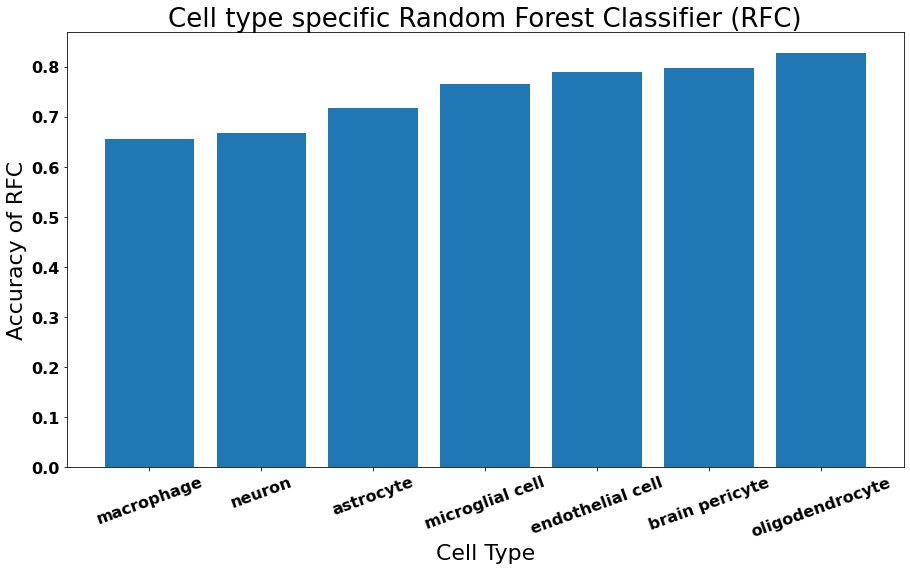

In [71]:
inxs = np.argsort(CT_accuracy)
fig, axs = plt.subplots(figsize = (15, 8))
plt.bar(np.arange(len(CT_accuracy)), [CT_accuracy[inx] for inx in inxs])
plt.xticks(np.arange(len(CT_accuracy)), [cell_types[inx] for inx in inxs], rotation=20)
plt.xlabel('Cell Type', **{'size':22})
plt.ylabel('Accuracy of RFC', **{'size':22})
plt.title('Cell type specific Random Forest Classifier (RFC)', **{'size' : 26})
plt.plot()

In [53]:
np.argsort(clf.feature_importances_)

array([-1309,  -888, -1015, ...,  -926,  -410,  -642])

In [43]:
X_train.mean(axis = 1), X_train.std(axs)

I7_B001354                  0.147170
E17_B001061                 0.375767
D15_B002518                 0.177896
K21_B000919                -0.173493
G6_B003904                 -0.024067
E11_B003904                -0.032016
A10_B002705                 0.260932
I14.MAA000605.3_10_M.1.1    0.033282
J10_B002702                -0.032111
E2_B001060                 -0.060825
F15_B001217                 0.052897
H2_B001620                  0.337258
G13.MAA000604.3_10_M.1.1   -0.148716
P2_B001061                 -0.019287
H12_B001618                -0.189027
B14_B002705                 0.038011
H13_B002518                 0.171584
C22_B003907                -0.197679
F18_B001620                 0.216880
J3_B001620                 -0.092474
P7_B003907                  0.464695
E9_B001061                  0.080365
J16.MAA000571.3_9_M.1.1     0.047435
E10_B001618                -0.180402
O1_B001620                  0.005086
K5_B003232                 -0.113893
A2_B003904                 -0.195042
P

In [44]:
X_train.T

,I7_B001354,E17_B001061,D15_B002518,K21_B000919,G6_B003904,E11_B003904,A10_B002705,I14.MAA000605.3_10_M.1.1,J10_B002702,E2_B001060,...,A6_B001618,A21_B001620,J6_B001618,P18.B003279.3_38_F.1.1,F11_B002702,E1_B003907,F9_B001354,G14_B001618,E15.B003279.3_38_F.1.1,F19_B001618
0610007P22Rik,0.221485,-0.118599,-0.118599,-0.118599,-0.118599,-0.118599,-0.118599,-0.118599,-0.118599,0.158445,...,-0.118599,-0.118599,-0.118599,-0.118599,-0.118599,-0.118599,-0.118599,-0.118599,-0.118599,-0.118599
0610010O12Rik,-0.091196,-0.091196,-0.091196,-0.091196,-0.091196,-0.091196,-0.091196,-0.091196,-0.091196,-0.091196,...,-0.091196,-0.091196,-0.091196,-0.091196,-0.091196,-0.091196,-0.091196,-0.091196,-0.091196,-0.091196
0610012G03Rik,-0.095582,-0.202864,-0.202864,-0.202864,1.114888,-0.202864,-0.202864,0.044088,-0.202864,-0.202864,...,-0.202864,-0.188695,-0.202864,-0.202864,-0.202864,-0.202864,-0.202864,-0.202864,-0.202864,0.005628
0610037P05Rik,0.937155,-0.191634,-0.191634,-0.191634,-0.191634,-0.191634,-0.191634,-0.191634,-0.191634,-0.191634,...,-0.191634,2.047738,-0.191634,-0.191634,-0.191634,-0.191634,-0.191634,-0.191634,-0.191634,-0.191634
1110001J03Rik,-0.186116,0.949687,-0.186116,-0.186116,-0.186116,-0.186116,-0.186116,-0.186116,-0.186116,-0.186116,...,-0.186116,-0.186116,1.807849,-0.186116,-0.186116,-0.186116,-0.186116,0.142005,-0.186116,-0.186116
1110002B05Rik,-0.299918,0.592193,1.471454,-0.296246,0.078220,-0.299918,-0.299918,-0.299918,-0.299918,-0.298082,...,-0.299918,-0.299918,-0.299918,-0.208137,2.314002,-0.299918,-0.299918,-0.299918,0.269124,-0.270548
1110003E01Rik,-0.169333,0.476968,-0.267079,-0.272420,0.899468,-0.272420,-0.272420,-0.019241,0.066220,-0.272420,...,-0.272420,-0.214200,1.036206,-0.220609,0.165569,2.557951,-0.272420,-0.226485,-0.272420,-0.221678
1110004F10Rik,-0.270281,1.064949,-0.256813,-0.270281,-0.270281,-0.270281,-0.270281,-0.270281,-0.270281,-0.270281,...,-0.270281,-0.270281,-0.260661,-0.262585,1.209247,-0.270281,-0.270281,-0.270281,2.046170,-0.235649
1110008P14Rik,-0.211801,-0.211801,-0.211801,-0.211801,-0.211801,-0.211801,6.229143,-0.211801,-0.052547,-0.211801,...,-0.211801,-0.052547,-0.211801,-0.211801,-0.211801,-0.211801,-0.211801,-0.211801,-0.211801,-0.211801
1110014N23Rik,-0.231509,-0.231509,-0.231509,-0.231509,-0.231509,-0.231509,-0.231509,1.740151,-0.022913,0.319984,...,-0.231509,-0.231509,-0.231509,-0.231509,-0.231509,-0.231509,-0.231509,-0.231509,-0.231509,-0.231509
